In [1]:
from os import system
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta
import time
import scipy.stats as sts

# from apscheduler.schedulers.background import BackgroundScheduler
# from apscheduler.triggers.interval import IntervalTrigger
import matplotlib.dates as mdates
import json
import urllib
import logging, sys

In [2]:
try:
    print('Trying to import keras...')
    import keras
    print('Keras imported.')
except ImportError:
    print('Keras import failed...')
    print('Installing keras in conda environment...')
    import sys
    !conda install --yes --prefix {sys.prefix} keras

Trying to import keras...
Keras import failed...
Installing keras in conda environment...
Solving environment: done

## Package Plan ##

  environment location: /home/amadeusz/anaconda3/envs/nowe

  added / updated specs: 
    - keras


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    singledispatch-3.4.0.3     |   py36h7a266c3_0          15 KB
    unicodecsv-0.14.1          |   py36ha668878_0          25 KB
    astropy-3.1                |   py36h7b6447c_0         7.2 MB
    patsy-0.5.1                |           py36_0         380 KB
    h5py-2.8.0                 |   py36h989c5e5_3         1.1 MB
    xlwt-1.3.0                 |   py36h7b00a1f_0         162 KB
    nbformat-4.4.0             |   py36h31c9010_0         137 KB
    odo-0.5.1                  |   py36h90ed295_0         193 KB
    blaze-0.11.3               |           py36_0         603 KB
    scikit-learn-0.20.1        |  

singledispatch-3.4.0 | 15 KB     | ##################################### | 100% 
unicodecsv-0.14.1    | 25 KB     | ##################################### | 100% 
astropy-3.1          | 7.2 MB    | ##################################### | 100% 
patsy-0.5.1          | 380 KB    | ##################################### | 100% 
h5py-2.8.0           | 1.1 MB    | ##################################### | 100% 
xlwt-1.3.0           | 162 KB    | ##################################### | 100% 
nbformat-4.4.0       | 137 KB    | ##################################### | 100% 
odo-0.5.1            | 193 KB    | ##################################### | 100% 
blaze-0.11.3         | 603 KB    | ##################################### | 100% 
scikit-learn-0.20.1  | 5.7 MB    | ##################################### | 100% 
mkl-service-1.1.2    | 132 KB    | ##################################### | 100% 
anaconda-2018.12     | 51 KB     | ##################################### | 100% 
seaborn-0.9.0        | 379 K

In [2]:
# keras
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [18]:
days = list()
def preprocess_data():
    for day in range(4,8):
        data_in = pd.read_csv("/media/amadeusz/16A4DBE9A4DBC8FF/TF_NEW/Tensorflow-Bootcamp-master/test/2015-06-0{}/series_0{}_full_day_grouped_in.csv".format(day,day))
        data_out = pd.read_csv("/media/amadeusz/16A4DBE9A4DBC8FF/TF_NEW/Tensorflow-Bootcamp-master/test/2015-06-0{}/series_0{}_full_day_grouped_out.csv".format(day,day))
        data = data_in
        data['obyt'] = data_out['ibyt']
        data['ts'] = pd.to_datetime(data['ts'], format='%Y-%m-%d %H:%M:%S', errors='ignore')
        data['ibyt'] = data['ibyt'].apply(lambda x: x*1/1e9)
        data['obyt'] = data['obyt'].apply(lambda x: x*1/1e9)
        data['over_byt'] = data['ibyt'] + data['obyt']
        data = data.groupby(['ts']).sum()
        data.index.name = None
        data = data.groupby([data.index.hour, data.index.minute]).sum()
        data['hours'] = data.index.labels[0]
        data['minutes'] = data.index.labels[1]
        days.append(data)
preprocess_data()

In [19]:
x = range(days[0].shape[0]*len(days))
r = list()
y_in = list()
y_out = list()
y_over = list()
y_hours = list()
y_minutes = list()
for day in days:
    r = r + day.index.levels[0].tolist()
    y_in = y_in + day.groupby(level=[0,1]).sum()['ibyt'].tolist()
    y_out = y_out + day.groupby(level=[0,1]).sum()['obyt'].tolist()
    y_over = y_over + day.groupby(level=[0,1]).sum()['over_byt'].tolist()
    y_hours = y_hours + day.groupby(level=[0,1]).sum()['hours'].tolist()
    y_minutes = y_minutes + day.groupby(level=[0,1]).sum()['minutes'].tolist()

In [20]:
dataset = pd.DataFrame(data=np.asarray(y_in), columns=['in'])
dataset['out'] = np.asarray(y_out)
dataset['overall'] = np.asarray(y_over)
dataset['hour'] = np.asarray(y_hours)
dataset['minute'] = np.asarray(y_minutes)

In [22]:
dataset.to_csv('AGH_traffic.csv')

([<matplotlib.axis.XTick at 0x7f4227220d30>,
 <a list of 48 Text xticklabel objects>)

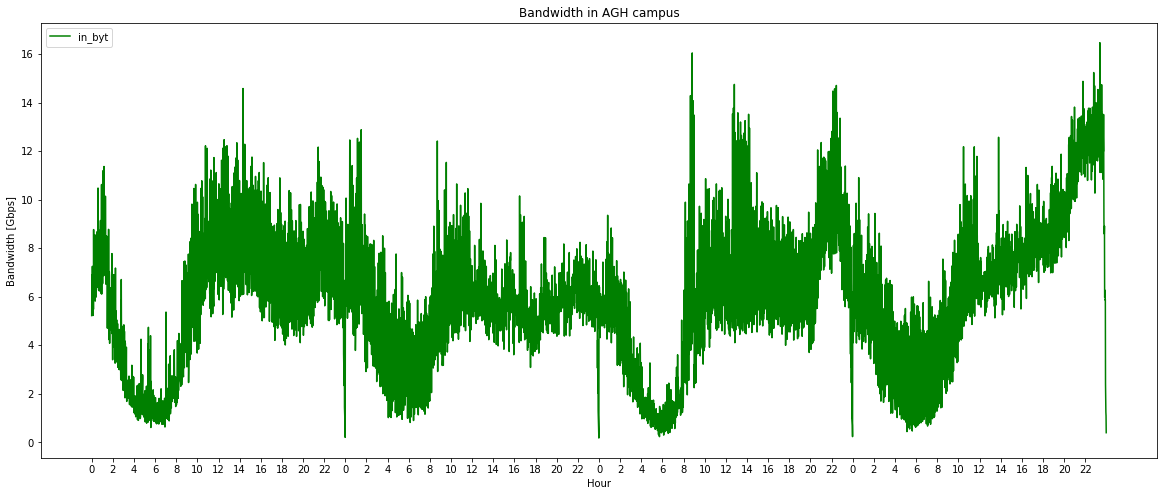

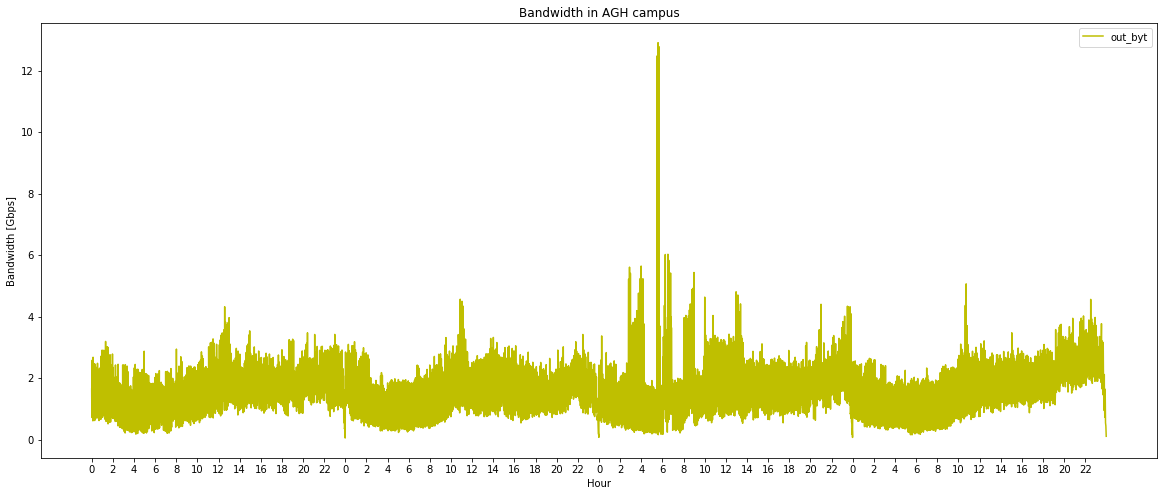

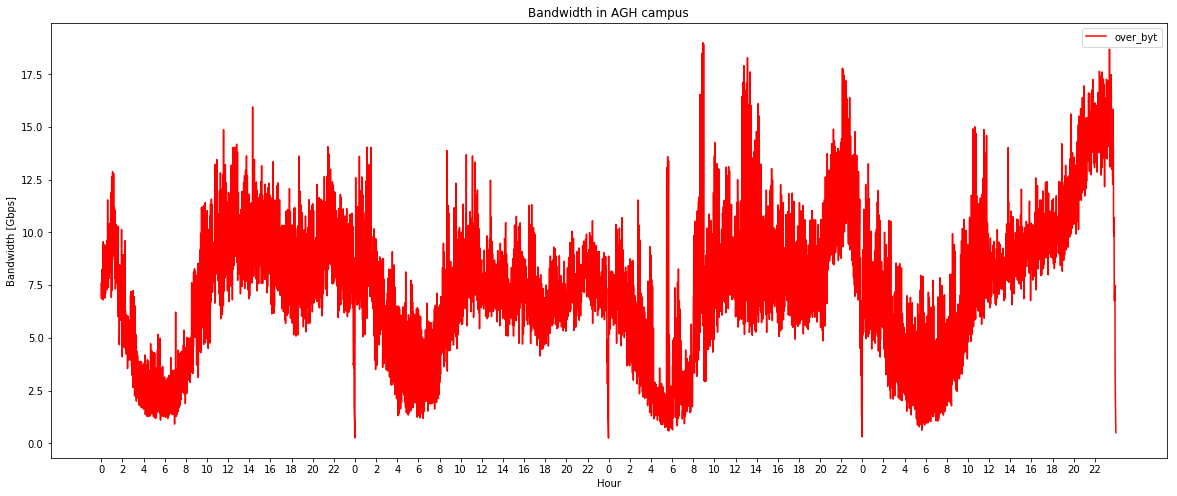

In [22]:
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(20,8))
plt.plot(x, y_in, 'g', label='in_byt')
plt.legend()
plt.title('Bandwidth in AGH campus')
plt.ylabel('Bandwidth [Gbps]')
plt.xlabel('Hour')
plt.xticks(range(0,days[0].shape[0]*len(days),120), r[::2])

plt.figure(figsize=(20,8))
plt.plot(x, y_out, 'y', label='out_byt')
plt.legend()
plt.title('Bandwidth in AGH campus')
plt.ylabel('Bandwidth [Gbps]')
plt.xlabel('Hour')
plt.xticks(range(0,days[0].shape[0]*len(days),120), r[::2])

plt.figure(figsize=(20,8))
plt.plot(x, y_over, 'r', label='over_byt')
plt.legend()
plt.title('Bandwidth in AGH campus')
plt.ylabel('Bandwidth [Gbps]')
plt.xlabel('Hour')
plt.xticks(range(0,days[0].shape[0]*len(days),120), r[::2])

# Model
source: https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/

In [17]:
# univariate multi-step encoder-decoder convlstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D

# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[0:-1440], data[-1440:]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/30))
    test = array(split(test, len(test)/30))
    return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=30):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)

# train the model
def build_model(train, n_steps, n_length, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 1, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape into subsequences [samples, time steps, rows, cols, channels]
    train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(250, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(150, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

# make a forecast
def forecast(model, history, n_steps, n_length, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [samples, time steps, rows, cols, channels]
    input_x = input_x.reshape((1, n_steps, 1, n_length, 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

# evaluate a single model
def evaluate_model(train, test, n_steps, n_length, n_input, model_name):
    # fit model
    model = build_model(train, n_steps, n_length, n_input)
    # serialize model to JSON
    model_json = model.to_json()
    with open("{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("{}.h5".format(model_name))
    print("Saved model to disk")
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_steps, n_length, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores


In [4]:
dataset = pd.read_csv('overall_traffic_SDN_test.csv', index_col=0)

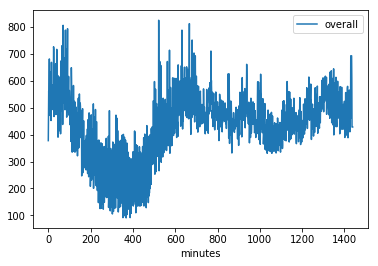

In [29]:
dataset.plot()

In [5]:
data = dataset['overall']
for i in range(240):
    data = data.append(dataset['overall'])

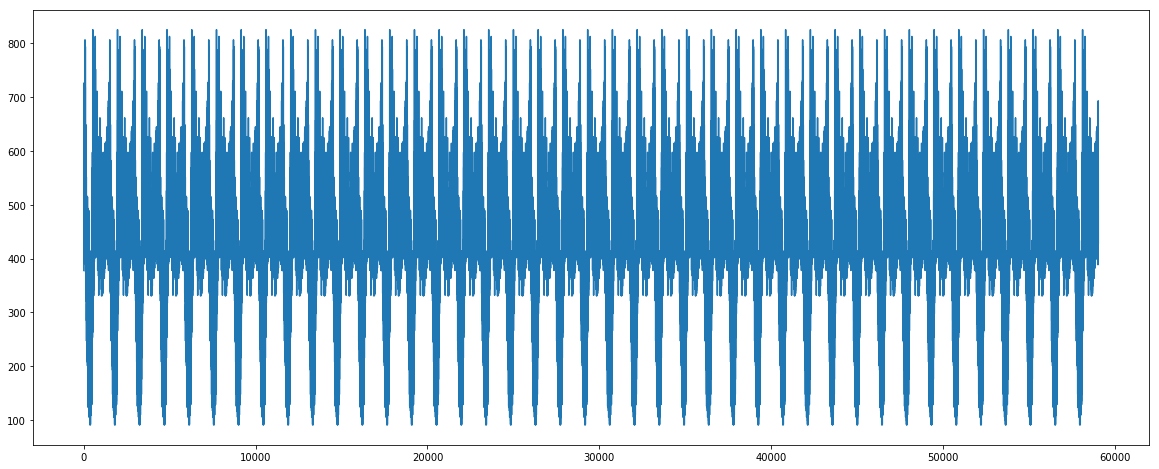

In [11]:
plt.figure(figsize=(20,8))
plt.plot(data.values)

In [18]:
# load the new file
# data = dataset['overall']
# split into train and test
train, test = split_dataset(data.values)
train = train.reshape(train.shape[0], train.shape[1], 1)
test = test.reshape(test.shape[0], test.shape[1], 1)
print(train.shape, test.shape)

(1920, 30, 1) (48, 30, 1)


In [28]:
model_name = 'model_240_dni'
# define the number of subsequences and the length of subsequences
n_steps, n_length = 10, 30
# define the total days to use as input
n_input = n_length * n_steps
score, scores = evaluate_model(train, test, n_steps, n_length, n_input, model_name)

In [31]:
# summarize scores
summarize_scores('lstm', score, scores)

In [30]:
# plot scores
days = range(30)
pyplot.plot(days, scores, marker='o', label='lstm')

In [19]:
# load json and create model
from keras.models import model_from_json
json_file = open('model_240_dni.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model_240_dni.h5")
print("Loaded model from disk")
# history is a list of weekly data
# history is a list of weekly data
history = [x for x in train]
# walk-forward validation over each week
predictions = list()
for i in range(len(test)):
    # predict the week
    yhat_sequence = forecast(model, history, n_steps, n_length, n_input)
    # store the predictions
    predictions.append(yhat_sequence)
    # get real observation and add to history for predicting the next week
    history.append(test[i, :])
# evaluate predictions days for each week
predictions = array(predictions)
score, scores = evaluate_forecasts(test[:, :, 0], predictions)

Loaded model from disk


In [20]:
predictions.shape

(48, 30, 1)

In [21]:
test.shape

(48, 30, 1)

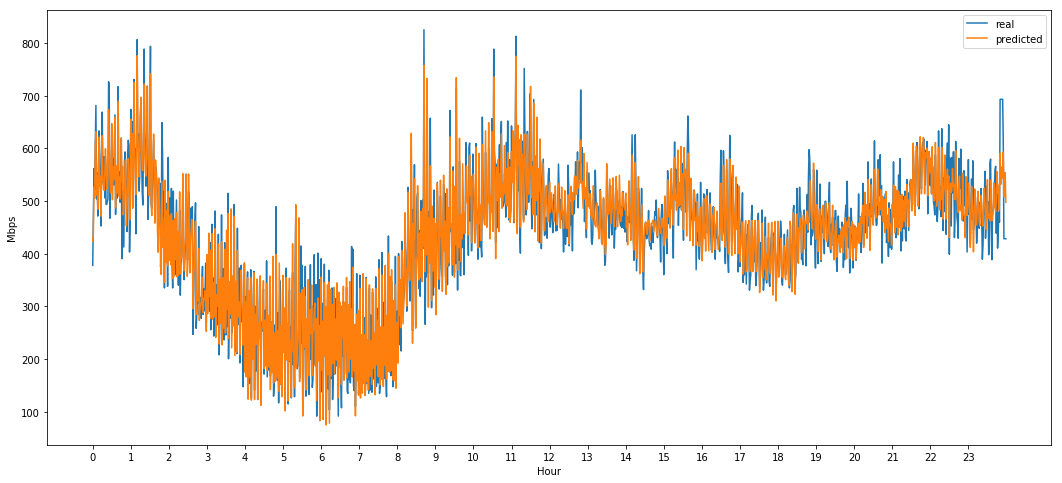

In [27]:
pred = list()
test_ = list()
for i in predictions.reshape(predictions.shape[0]*predictions.shape[1]).tolist():
    pred.append(i)
for i in test.reshape(test.shape[0]*test.shape[1]).tolist():
    test_.append(i)
plt.figure(figsize=(18,8))
plt.plot(test_, label='real')
plt.plot(pred, label='predicted')
ticks = [x*60 for x in range(24)]
labels = [x for x in range(24)]
plt.xticks(ticks, labels)
plt.xlabel('Hour')
plt.ylabel('Mbps')
plt.legend()